# Topic modeling in codecentric blog

In [1]:
from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import udf, col, date_format

from pyspark.sql.types import StringType, FloatType, ArrayType

from pyspark.ml.feature import CountVectorizer, CountVectorizerModel, IDF, RegexTokenizer, StopWordsRemover
from pyspark.ml.clustering import LDA, LocalLDAModel
from pyspark.ml import Pipeline 

# Data preparation

## Load data from mysql into spark dataframe

In [2]:
spark = SparkSession.builder.getOrCreate()

# read from mysql table, only use published posts sorted by date
df_posts = ((spark.read.format("jdbc")
             .option("url", "jdbc:mysql://localhost/ccblognew")
             .option("driver", "com.mysql.jdbc.Driver")
             .option("dbtable", "wp_2_posts")
             .option("user", "root")
             .load()
            ).filter("post_type == 'post'")
            .filter("post_status == 'publish'")
            .sort("post_date"))

df_author = (spark.read.format("jdbc")
             .option("url", "jdbc:mysql://localhost/ccblog")
             .option("driver", "com.mysql.jdbc.Driver")
             .option("dbtable", "wp_users")
             .option("user", "root").load())

# removing some very short and strange posts
rm_ID = ['4259', '2259', '4433', '9195', '3839', '15971', '7895', '7904']
df_posts = df_posts.drop('post_date_gmt').drop('post_modified_gmt')[~ df_posts.ID.isin(rm_ID)]
#df_posts.printSchema()

print('Number of posts: ', df_posts.count())

Number of posts:  1292


In [3]:
# raw text of the first entry 
df_posts.select('post_content').take(1)[0][0]

'In fast allen unseren Projekten setzen wir auf eine leichtgewichtige Architektur im Java Enterprise Umfeld und setzen dabei in vielen Projekten auf das <a href="http://www.springframework.org">Springframework</a> und dessen Subprojekte wie <a href="http://static.springframework.org/spring-batch/">Spring Batch</a> oder <a href="http://www.springframework.org/webflow">Spring Webflow</a>. Bereits in diesem Früjahr auf der <a href="http://www.jax.de">JAX</a> haben wir uns deshalb mit <a href="http://www.springsource.com/">SpringSource</a> über eine mögliche Partnerschaft unterhalten und diese jetzt auch offiziell bekannt gegeben.\r\n\r\nDie Kombination aus unserem Java EE Knowhow in den Bereichen Performance, Architektur und Open Source und dem Produktportfolio von SpringSource erschien beiden Unternehmen als optimale Lösung für unsere Kunden. Gerade die Support Angebote für Produktion und Entwicklung, die hervorragenden Core Spring Trainings und die Enterprise Version von Spring, mit Mon

## Normalize text and tokenize
extract text from HTML, remove punctuation, lowercase, tokenize

In [5]:
from bs4 import BeautifulSoup
import re

extractText = udf(
    lambda d: BeautifulSoup(d, "lxml").get_text(strip=False), StringType())
removePunct = udf(
    lambda s: re.sub(r'[^a-zA-Z0-9]|[0-9]', r' ', s).strip().lower(), StringType())

# normalize the post content (remove html tags, punctuation and lower case..)
df_posts_norm = df_posts.withColumn("text", removePunct(extractText(df_posts.post_content)))

# tokenize 
tokenizer = RegexTokenizer(inputCol="text", outputCol="words",
                           gaps=True, pattern=r'\s+', minTokenLength=2)
df_tokens = tokenizer.transform(df_posts_norm)

## Select english language via ratio of stopwords

In [6]:
from nltk.corpus import stopwords

englishSW = set(stopwords.words('english'))
germanSW = set(stopwords.words('german'))

RatioEng = udf(lambda l: len(set(l).intersection(englishSW)) / len(l))
RatioGer = udf(lambda l: len(set(l).intersection(germanSW)) / len(l))

df_tokens_en = df_tokens.withColumn("ratio_en", RatioEng(df_tokens['words'])) \
    .withColumn("ratio_ge", RatioGer(df_tokens['words'])) \
    .withColumn("Eng", col('ratio_en') > col('ratio_ge')) \
    .filter('Eng')

df_tokens_en.count()

694

## Remove stopwords and stemming

In [7]:
moreStopWords = \
    ['', 'com', 'de', 'eu', 'cf', 'pm', 'like', 'one', 'using', 'new', 'also',
     'really', 'need', 'caption', 'since', 'change', 'young', 'align', 'width',
     'attachment', 'number', 'know', 'two', 'use', 'see', 'get', 'first', 'good',
     'next', 'well', 'day', 'way', 'fruit', 'different', 'let', 'lot', 'would',
     'already', 'set', 'user', 'even', 'might', 'many', 'different', 'crazy',
     'may', 'could', 'still', 'probably', 'make', 'write', 'used', 'written',
     'go', 'us', 'yes', 'seen', 'behind', 'much', 'makes', 'via', 'based',
     'choose', 'presented', 'away', 'hence', 'wants', 'please', 'add',
     'something', 'conclusion', 'able', 'describe', 'thing', 'likely',
     'lots', 'sense', 'higher', 'every', 'right', 'sure', 'quite', 'without',
     'within', 'codecentric', 'follow', 'look', 'example', 'examples', 'short',
     'cancel', 'promise', 'means', 'almost', 'large', 'besides']

swRemover = StopWordsRemover(inputCol=tokenizer.getOutputCol(), outputCol="filtered")
swRemover.setStopWords(swRemover.getStopWords() + moreStopWords)

df_finalTokens = swRemover.transform(df_tokens_en)

# Stemming
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer("english", ignore_stopwords=False)
udfStemmer = udf(lambda l: [stemmer.stem(s) for s in l], ArrayType(StringType()))

df_finalTokens = df_finalTokens.withColumn("filteredStemmed",
                                           udfStemmer(df_finalTokens["filtered"]))

# Create count (feature) vectors

In [7]:
%%time
cv = CountVectorizer(inputCol="filteredStemmed", outputCol="features",
                     vocabSize=2500,
                     minTF=2, # minium number of times a word must appear in a document
                     minDF=4) # minimun number of documents a word must appear in

cvModel = cv.fit(df_finalTokens)

countVectors = (cvModel
                .transform(df_finalTokens)
                .select("ID", "features").cache())

corpusSize = countVectors.count()
print(corpusSize, len(cvModel.vocabulary))  # how many documents, vocab size

694 2500
CPU times: user 56.9 ms, sys: 21.2 ms, total: 78.1 ms
Wall time: 58.4 s


# Train LDA model on complete dataset and evaluate

### Train Model

In [ ]:
%%time
#df_training, df_testing = countVectors.randomSplit([0.9, 0.1], 1)
df_training, df_testing = countVectors.randomSplit([1.0, 0.0], 1)
print('Training and testing documents: ', df_training.count(), df_testing.count())

numTopics = 20 # number of topics

lda = LDA(k = numTopics, seed = 1, optimizer="online", optimizeDocConcentration=True,
          maxIter = 50, # number of iterations
          learningDecay = 0.51, # kappa, learning rate
          learningOffset=64., # tau_0, a larger (positive) value downweights early iterations
          subsamplingRate = 0.05, # mini batch fraction 
          )

ldaModel = lda.fit(df_training)
lpt, lp = ldaModel.logPerplexity(df_testing), ldaModel.logPerplexity(df_training)
print("Perplexity on testing and training data: " + str(lp) + ',' + str(lpt))

# Print topics and top-weighted terms
topics = ldaModel.describeTopics(maxTermsPerTopic=10)
vocabArray = cvModel.vocabulary

ListOfIndexToWords = udf(lambda wl: list([vocabArray[w] for w in wl]))
FormatNumbers = udf(lambda nl: ["{:1.4f}".format(x) for x in nl])

topics.select(ListOfIndexToWords(topics.termIndices).alias('words')).show(truncate=False, n=numTopics)
topics.select(FormatNumbers(topics.termWeights).alias('weights')).show(truncate=False, n=numTopics)


#### Save Model

In [9]:
# Save model
#print(ldaModel.isDistributed())
path = "target/org/apache/spark/PythonLDA/"

model_number = '7'
cvModel.save(path + 'CVModel_stem'+ model_number)
ldaModel.save(path + 'LDAModel_stem'+ model_number)
lda.save(path + 'LDA_'+ model_number)

### Identify top terms and top Document

### Load Model

In [8]:
model_number = '7'

# load model and display topics and weights
path = "target/org/apache/spark/PythonLDA/"
usedLDAModel = LocalLDAModel.load(path + 'LDAModel_stem_' + model_number)
usedCVModel = CountVectorizerModel.load(path + 'CVModel_stem_' + model_number)

maxTermsPerTopic = 5

# Print the topics, showing the top-weighted terms for each topic.
topics = usedLDAModel.describeTopics(maxTermsPerTopic=maxTermsPerTopic)
vocabArray = usedCVModel.vocabulary
numTopics = topics.count()

ListOfIndexToWords = udf(lambda wl: list([vocabArray[w] for w in wl]), ArrayType(StringType()))
FormatNumbers = udf(lambda nl: [float("{:1.4f}".format(x)) for x in nl], ArrayType(FloatType()))

toptopics = topics.select((topics.topic + 1).alias('topic'),
                          ListOfIndexToWords(topics.termIndices).alias('words'),
                          FormatNumbers(topics.termWeights).alias('weights'))
toptopics.show(truncate=False, n=numTopics)
print('Topics:', numTopics, 'Vocabulary:', len(vocabArray))

+-----+----------------------------------------+----------------------------------------+
|topic|words                                   |weights                                 |
+-----+----------------------------------------+----------------------------------------+
|1    |[test, file, applic, server, project]   |[0.0596, 0.0256, 0.0175, 0.0153, 0.0134]|
|2    |[game, play, player, test, program]     |[0.0803, 0.0439, 0.0287, 0.0253, 0.0242]|
|3    |[build, plugin, run, imag, maven]       |[0.0444, 0.0373, 0.0308, 0.0299, 0.0252]|
|4    |[product, request, valid, stori, featur]|[0.0296, 0.0282, 0.0225, 0.0193, 0.0193]|
|5    |[java, gc, time, jvm, memori]           |[0.056, 0.0448, 0.0284, 0.0249, 0.0247] |
|6    |[data, index, field, queri, oper]       |[0.0705, 0.0316, 0.0188, 0.0187, 0.0181]|
|7    |[state, node, system, cluster, data]    |[0.0406, 0.0207, 0.0204, 0.0159, 0.0157]|
|8    |[page, text, search, element, box]      |[0.0414, 0.0368, 0.0355, 0.0232, 0.023] |
|9    |[pe

### Details of all topics

In [11]:
# find the top documents accoring to lda for all topics 
countVectors = (usedCVModel.transform(df_finalTokens).select("ID", "features")
                .cache())

df = usedLDAModel.transform(countVectors)

topWords = topics.select(ListOfIndexToWords(topics.termIndices).alias('words')).take(numTopics)

nTopDoc = 2  # show single top document (1) or also second (2) ..

for i in range(0, numTopics):
    ntopic = i  # which topic 
    print('Topic ' + str(ntopic) + '\n')  #+ ' Label: ' + topiclist[ntopic] +'\n')

    df_sliced = df.select("ID", "topicDistribution") \
        .rdd.map(lambda r: Row(ID=int(r[0]), sliced=float(r[1][ntopic]))).toDF()

    DocIDs = df_sliced.sort(df_sliced.sliced.desc()).take(nTopDoc)
    print(DocIDs)
    print('Top Document:')
    for d_id in DocIDs:
        df_finalTokens.filter(df_finalTokens.ID == d_id[0]) \
            .join(df_author.withColumnRenamed("ID", "post_author"), on='post_author') \
            .select('post_title', 'display_name') \
            .show(truncate=False)

    print('Top terms:')
    print(topWords[ntopic][0], '\n')
    print('===================================================')


Topic 0

[Row(ID=25309, sliced=0.9836743611636042), Row(ID=7785, sliced=0.9447441890776909)]
Top Document:
+----------------------------------------------------------------+------------+
|post_title                                                      |display_name|
+----------------------------------------------------------------+------------+
|Testing JavaScript on various platforms with Karma and SauceLabs|Ben Ripkens |
+----------------------------------------------------------------+------------+

+--------------------------------+--------------+
|post_title                      |display_name  |
+--------------------------------+--------------+
|Robot Framework and RIDE - To Go|Thomas Jaspers|
+--------------------------------+--------------+

Top terms:
['test', 'file', 'applic', 'server', 'project'] 

Topic 1

[Row(ID=24700, sliced=0.8112175304578934), Row(ID=24877, sliced=0.7343587865536011)]
Top Document:
+--------------------------+-------------------------+
|post_title      

### Details of single topic

In [12]:
# find the top documents accoring to lda for topic number ntopic
ntopic = 19 # which topic 0..numTopics
nTopDoc = 1 # show top document (1) or second (2) ..

#df = usedLDAModel.transform(df_training)
countVectors = (usedCVModel
                .transform(df_finalTokens)
                .select("ID", "features")
                .cache())

df = usedLDAModel.transform(countVectors)

df_sliced = df.select("ID","topicDistribution").rdd.map(lambda r: Row(ID = int(r[0]), sliced = float(r[1][ntopic]))).toDF()
topDocID = df_sliced.sort(df_sliced.sliced.desc()).take(nTopDoc)[nTopDoc-1][0]
print(topDocID)
print('Topic ' + str(ntopic) +'\n')

print('Top Document:')
df_finalTokens.filter(df_finalTokens.ID == topDocID)\
    .join(df_author.withColumnRenamed("ID","post_author"), on = 'post_author')\
    .select('post_title','display_name')\
    .show(truncate = False)

print('Top 5 terms:')
print(topics.select(ListOfIndexToWords(topics.termIndices).alias('words')).take(numTopics)[ntopic][0], '\n')

39020
Topic 19

Top Document:
+------------------------------------+-------------+
|post_title                          |display_name |
+------------------------------------+-------------+
|New features in iOS 10 Notifications|Martin Berger|
+------------------------------------+-------------+

Top 5 terms:
['app', 'notif', 'object', 'return', 'null'] 



### Count top documents for each topics and plot result

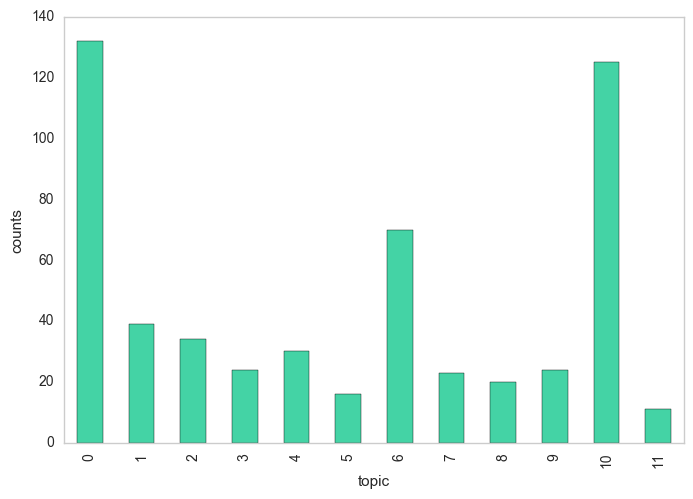

In [13]:
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_style("whitegrid")

countVectors = (usedCVModel
                .transform(df_finalTokens)
                .select("ID", "features"))

countTopDocs = (usedLDAModel
                .transform(countVectors)
                .select("topicDistribution")
                .rdd.map(lambda r: Row( nTopTopic = int(np.argmax(r)))).toDF()
                .groupBy("nTopTopic").count().sort("nTopTopic"))

pdf = countTopDocs.toPandas()
pdfLess = pdf.drop(pdf.index[[1,3,7,8,10,11,14,15]]).reset_index()

pdfLess.plot(color = '#44D3A5', legend = False,
                           kind = 'bar', use_index = True, y = 'count', grid = False)
plt.xlabel('topic')
plt.ylabel('counts')

plt.show()

### Top documents - Time evolution for 3 Top Topics

In [9]:
import numpy as np

countVectors = (usedCVModel
                .transform(df_finalTokens)
                .select("ID", "post_date", "features"))
data_t0 = []
data_t12 = []
data_t18 = []
year = []
                
for i in range(0,9):
    countVectors_tmp = countVectors.filter(
        date_format("post_date", "yyyy").cast('int') == 2008+i)

    countTopDocs = (usedLDAModel
             .transform(countVectors_tmp)
             .select("topicDistribution")
             .rdd.map(lambda r: Row( nTopTopic = int(np.argmax(r)))).toDF()
             .groupBy("nTopTopic").count().sort("nTopTopic"))

    
    # it is possible that for a topic there is no top documents
    # and does not appear in the list - append(0)
    countsInThisYear = countTopDocs.filter("nTopTopic == 0").select('count').collect()
    if (countsInThisYear != []): data_t0.append(countsInThisYear[0][0])
    else: data_t0.append(0)
           
    countsInThisYear = countTopDocs.filter("nTopTopic == 12").select('count').collect()
    if (countsInThisYear != []): data_t12.append(countsInThisYear[0][0])
    else: data_t12.append(0)

    countsInThisYear = countTopDocs.filter("nTopTopic == 18").select('count').collect()
    if (countsInThisYear != []): data_t18.append(countsInThisYear[0][0])
    else: data_t18.append(0)

    year.append(str(2008+i))

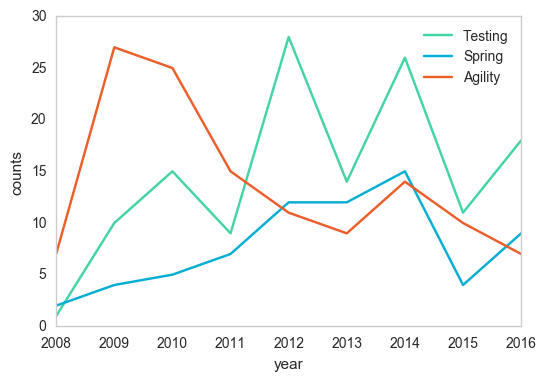

In [11]:
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set_style("whitegrid")

df = pd.DataFrame({
     'year': year,
     'counts_t0': data_t0,
     'counts_t12': data_t12,
     'counts_t18': data_t18
    })

df.plot(color = ['#44D3A5', '#04AED2','#EB5E29'], kind = 'line', grid = False,
        y = ['counts_t0', 'counts_t12', 'counts_t18'], x = 'year')

plt.xlabel('year')
plt.ylabel('counts')
plt.legend(['Testing','Spring','Agility'])
plt.show()

### Prediction of a single Document

In [12]:
# this document is indeed about ...
indexPost = 0
idd = 34530 #Daniel Pape's Post on Pi

countVectors = usedCVModel.transform(df_finalTokens)

testTopicDistributions = usedLDAModel.transform(countVectors)

alist = testTopicDistributions.filter(testTopicDistributions.ID == idd).select("topicDistribution").collect()[0][0]
print([ (index+1,float("{0:.3f}".format(item)) ) for (index,item) in enumerate( alist ) ])

df_finalTokens.filter(df_finalTokens.ID == idd).select("post_title").collect()

[(1, 0.165), (2, 0.0), (3, 0.096), (4, 0.0), (5, 0.009), (6, 0.012), (7, 0.153), (8, 0.038), (9, 0.0), (10, 0.203), (11, 0.0), (12, 0.0), (13, 0.0), (14, 0.0), (15, 0.097), (16, 0.157), (17, 0.0), (18, 0.062), (19, 0.007), (20, 0.0)]


[Row(post_title='Calculating Pi with Apache Spark')]

### Prediction on my own blog article

In [13]:
my_doc = "my_article.html"

f = open(my_doc,"r")
my_post_content = f.read()
f.close()

# load post into Spark df, extract text, normalize, tokenize
df_my_post = spark.createDataFrame([(1,my_post_content)],["ID","post_content"])\
                  .withColumn("text", removePunct(extractText("post_content")))    
df_my_tokens = tokenizer.transform(df_my_post)

# remove stop words
df_my_finalTokens = swRemover.transform(df_my_tokens).withColumn("filteredStemmed",
                                           udfStemmer("filtered"))
# transfrom to count vectors
my_countVectors = usedCVModel.transform(df_my_finalTokens).select("ID", "features")
# apply loaded LDA model and get topic distribution
testTopicDistributions = usedLDAModel.transform(my_countVectors).select("topicDistribution").collect()[0][0]

# zip with index and remove less important topics (weight < 0.05)
myTopicDistributions = [ (index,float("{0:.3f}".format(item)) ) for (index,item) in enumerate( testTopicDistributions ) if item > 0.05 ]
# remove a non-meaningful topic
myTopicDistributions.remove((15, 0.074))
myTopicDistributions = sorted(myTopicDistributions, key=lambda x: x[1])

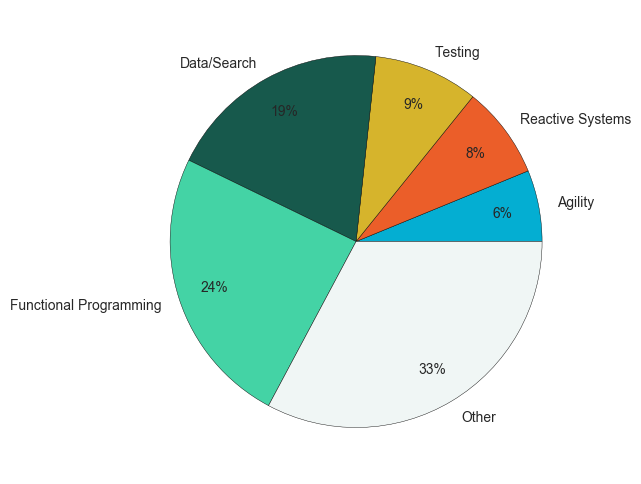

In [14]:
import matplotlib.pyplot as plt

# Set up the matplotlib figure
fig, ax = plt.subplots(1 ,figsize=(6, 6))
             
labels = ['Agility', 'Reactive Systems', 'Testing','Data/Search', 'Functional Programming','Other']
weights = list(list(zip(*myTopicDistributions))[1])
# add all other topics (sum)
weights.append(1-sum(weights))

plt.pie(weights, labels=labels, colors = ['#04AED2','#EB5E29', '#d6b42c', '#17594C','#44D3A5','#f0f6f5'], 
        autopct='%1.0f%%', pctdistance=0.8, labeldistance=1.1 )
plt.show()

### Visualization World Cloud

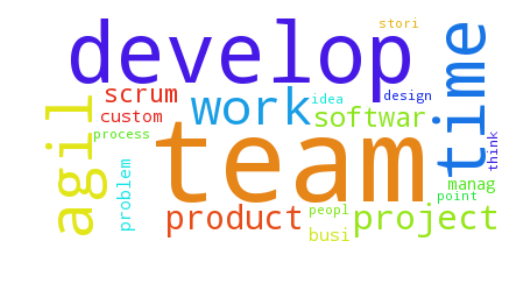

In [15]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

topic_k = 19 #1 , 13, 19
maxTermsPerTopic = 20

topics = usedLDAModel.describeTopics(maxTermsPerTopic=maxTermsPerTopic)

toptopics = topics.select((topics.topic + 1).alias('topic'),
                          ListOfIndexToWords(topics.termIndices).alias('words'),
                          FormatNumbers(topics.termWeights).alias('weights'))

words = toptopics.collect()[topic_k-1][1]

frequencies = toptopics.collect()[topic_k-1][2]
word_freq_dict = sorted(dict(zip(words,frequencies)).items(), reverse=True)

wordcloud = WordCloud(background_color="white",
                      max_font_size=100,relative_scaling=0.5,margin=5,
                      random_state=1, stopwords=None).generate_from_frequencies(word_freq_dict)

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# Historic evolution of topics

## LDA models for subsequent years including all previous years

In [160]:
%%time

model_number = '7'

# load counter vector model and lda 
path = "target/org/apache/spark/PythonLDA/"
usedCVModel = CountVectorizerModel.load(path + 'CVModel_stem_' + model_number)
usedLDA = LDA.load(path + 'LDA_stem_' + model_number)

vocabArray = usedCVModel.vocabulary
numTopics = usedLDA.getK()

ListOfIndexToWords = udf(lambda wl: list([vocabArray[w] for w in wl]), ArrayType(StringType()))
FormatNumbers = udf(lambda nl: [float("{:1.4f}".format(x)) for x in nl], ArrayType(FloatType()))
    
ldaPipeline = Pipeline(stages=[usedCVModel, usedLDA])

for i in range(0,7):
    df_finalTokens_tmp = df_finalTokens.filter(date_format("post_date", "yyyy").cast('int') <= 2010+i)
    print("years: 2008 - " + str(2010+i) + ", # of posts:",df_finalTokens_tmp.count())

    model = ldaPipeline.fit(df_finalTokens_tmp)

    # Print the topics, showing the top-weighted terms for each topic.
    topics = model.stages[-1].describeTopics(maxTermsPerTopic = 10)
    
    toptopics = topics.select((topics.topic + 1).alias('topic'),
                          ListOfIndexToWords(topics.termIndices).alias('words'),
                          FormatNumbers(topics.termWeights).alias('weights'))
    toptopics.show(truncate=False, n=numTopics)
    print('Topics:', numTopics, 'Vocabulary:', len(vocabArray))

    # save lda model, cv model
    model.stages[-1].save(path + 'LDAModel_c_until_year_' + str(2010+i))

years: 2008 - 2010, # of posts: 162
+-----+------------------------------------------------------------------------------------+--------------------------------------------------------------------------------+
|topic|words                                                                               |weights                                                                         |
+-----+------------------------------------------------------------------------------------+--------------------------------------------------------------------------------+
|1    |[test, robot, framework, keyword, execut, branch, specif, jython, librari, maven]   |[0.0893, 0.0511, 0.0457, 0.0425, 0.0293, 0.0215, 0.0187, 0.0186, 0.0172, 0.016] |
|2    |[employe, manag, employ, job, brand, market, clear, keep, focus, defin]             |[0.065, 0.0563, 0.0529, 0.0502, 0.043, 0.0328, 0.0308, 0.0245, 0.0225, 0.0187]  |
|3    |[privat, uri, endpoint, springframework, record, insur, inlin, super, verifi, jndi] |[0

## How do some words of topic "Agility" change over time

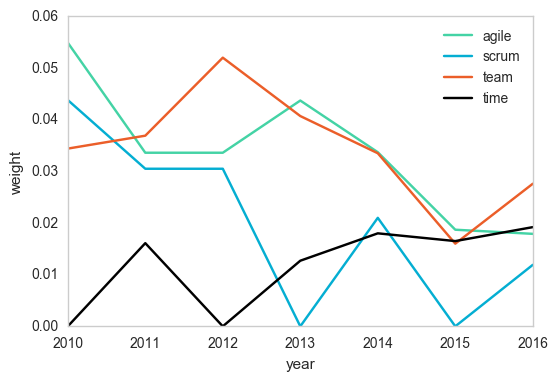

In [16]:
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set_style("whitegrid")

# AGILITY
df = pd.DataFrame({
 #    'year': [2010,2011,2012,2013,2014,2015,2016],
 #    'nPosts': [162,221,323,396,522,614,695],
 #    'words': ['agil', 'scrum', 'team', 'time', 'develop'],
     '2010': [0.0549,0.0438,0.0344,0.0,0.0246],
     '2011': [0.0336,0.0305,0.0369,0.0161,0.0335],
     '2012': [0.0336,0.0305,0.052,0.0,0.0335],
     '2013': [0.0437,0.0,0.0407,0.0127,0.0198],
     '2014': [0.0337,0.021,0.0335,0.018,0.0339],
     '2015': [0.0187,0.0,0.016,0.0165,0.0244],
     '2016': [0.0179,0.0119,0.0276,0.0192,0.0256]
    })
df = df.transpose()

df.plot(color = ['#44D3A5','#04AED2','#EB5E29','k'], kind = 'line', grid = False, use_index = True, y = [0,1,2,3])

plt.xlabel('year')
plt.ylabel('weight')
plt.legend(['agile', 'scrum', 'team', 'time'])
plt.show()

## How do some words of topic "Testing" change over time

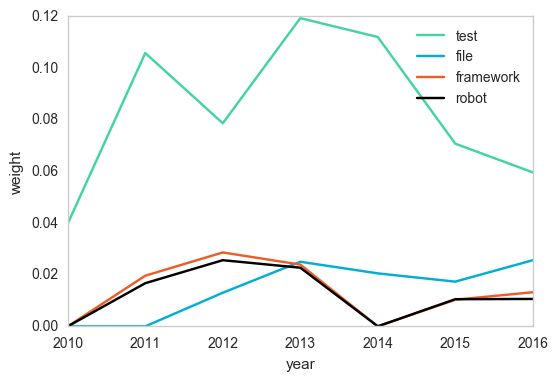

In [211]:
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set_style("whitegrid")

# TESTING
df = pd.DataFrame({
 #    'year': [2010,2011,2012,2013,2014,2015,2016],
 #    'nPosts': [162,221,323,396,522,614,695],
 #    'words': ['test', 'file', 'framework', 'robot'],
     '2010': [0.0398,0.0,0.0,0.0],
     '2011': [0.1058,0.0,0.0196,0.0167],
     '2012': [0.0786,0.013,0.0286,0.0256],
     '2013': [0.1193,0.025,0.0239,0.0227],
     '2014': [0.112,0.0205,0.0,0.0],
     '2015': [0.0707,0.0173,0.0103,0.0105],
     '2016': [0.0596,0.0256,0.0132,0.0106]
    })
df = df.transpose()

ax = df.plot(color = ['#44D3A5','#04AED2','#EB5E29','k'], kind = 'line', grid = False, use_index = True, y = [0,1,2,3])

plt.xlabel('year')
plt.ylabel('weight')
plt.legend(['test', 'file', 'framework', 'robot'])
plt.show()
fig = ax.get_figure()

fig.set_dpi(100)
fig.set_size_inches(9, 6)
#fig.set_tight_layout(True)
fig.savefig('test.svg')